# Ch3: Geometry & Algebra of Tensors
    
## 3.1 Motivation and Intuition

The data set is from http://www.models.life.ku.dk/nwaydata
in Matlab form, and can be read by scipy loadmat function, and saved as numpy arrays for easier loads later

The data has X variable as 3-way tensor of  5 samples in mode - 1 (rows) 5 × 51 × 201. , containing different amounts of tyrosine, tryptophan and phenylalanine amino acids belong to three amino acids dissolved in phosphate buffered water. The samples were measured by fluorescence (excitation 250-300 nm, emission 250-450 nm, 1 nm intervals) on a spectrofluorometer 

The data has Y variable, which is the ground truth,  the known concentrations of the three chemicals (mode-2) that are in the samples (mode-1) 

In [74]:
import math

def tensorisation_Values (Df, components, value="value", aggFunc=np.mean):
    if components >= Df.shape[1]:
        print ("Number of components must be less or equal to number of the columns in the input matrix. Exiting without creating the tensor")
        return
    minVals = []
    maxVals = []
    tensorShape = []
    for i in range(components):
        minVal = Df.iloc[:,i].min()
        # this will be an index, therefore starting from zero is necessary
        if minVal > 0:
            Df.iloc[:,i] += minVal
            minVal = 0
        if minVal < 0:
            Df.iloc[:,i] -= minVal
            minVal = 0
        minVals.append(minVal)
        # also the max value need to be positive non-zero, because it will be the tensor shape 
        maxVal = Df.iloc[:,i].max()
        if maxVal <= 0:
            Df.iloc[:,i] -= maxVal + 1
            maxVal = 1
        maxVals.append(maxVal)
        print("mode  " + str(i) + " max value =" + str(maxVal) + ", min value = " + str(minVal))
        tensorShape.append(int(maxVal)+1)

    # update the values in the array, to be used as indices
    for k,j in Df.iterrows():
            for i in range(components):
                j[i] = int(math.floor(j[i])) + abs(int(minVals[i])) + 1
    print (tensorShape)
    tensorShape = tuple(tensorShape) 
    tensor_array = np.zeros(tensorShape)
    count = 0
    for k,j in Df.iterrows():
        count = count + 1
        t_index = tuple(
            int(j[i]) for i in range(components)
        )
        tensor_array[t_index] = aggFunc(j[value])

    unique,counts = np.unique(tensor_array,return_counts=True)
    print("Unique Counts: " + str(dict(zip(unique,counts))))
    print("Count: " + str(count))
    return tensor_array

In [39]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np

userdata = pd.read_csv('data/GlobalLandTemperaturesByMajorCity.csv')
columns = ['dt','AverageTemperature','AverageTemperatureUncertainty','City','Country','Latitude','Longitude'] # such that these will be x
df=userdata[columns].copy()
Values = userdata["AverageTemperature"] # this will be the values of the tensor
df

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W
...,...,...,...,...,...,...,...
239172,2013-05-01,18.979,0.807,Xian,China,34.56N,108.97E
239173,2013-06-01,23.522,0.647,Xian,China,34.56N,108.97E
239174,2013-07-01,25.251,1.042,Xian,China,34.56N,108.97E
239175,2013-08-01,24.528,0.840,Xian,China,34.56N,108.97E


In [40]:
# We will tensorise in the same order mentioned in chapter 3 first section on motivational problem
# First example is one temperature value as a scalar (rank-zero tensor), which does not require tensorisation, just indexing will do
df.iloc[0, 1] # specifying the index values, which is not usually interpreted easily


26.704

In [41]:
df.loc[(df['City']== 'Abidjan') & (df['dt']=='1849-01-01') ,['AverageTemperature']] # specifing the values needed (city and date values)

,AverageTemperature
0,26.704


In [42]:
# Second example is all temperature values in this dataset or in a specific city as a vector (rank-one tensor), which does not require tensorisation, just indexing will do

df.loc[df['City'] == 'Abidjan']['AverageTemperature']

0       26.704
1       27.434
2       28.101
3       26.140
4       25.427
         ...  
1972    27.652
1973    26.157
1974    24.951
1975    24.541
1976       NaN
Name: AverageTemperature, Length: 1977, dtype: float64

In [43]:
# Third example is temperature values per city (rank-two tensor). We will do it using pivot tables, and again with tensorisation
# pivot tables are another method in handling multi-way analysis
# checking how many cardiac cases in each age value

cityTempMeans = df.pivot_table(values='AverageTemperature',
                               index='City', 
                               aggfunc=np.mean,               ## aggfunc='size', # size if you want to aggregate by frequency counting
                               fill_value=0)
cityTempMeans

,AverageTemperature
City,
Abidjan,26.163737
Addis Abeba,17.525073
Ahmadabad,26.529853
Aleppo,17.370587
Alexandria,20.312617
...,...
Tokyo,12.555998
Toronto,5.773911
Umm Durman,29.081291


In [44]:
cityTempMeans.iloc[0,0] # Average temperature for Abidjan by indexing the pivot table

26.16373719752392

In [45]:
df.loc[df['City'] == 'Abidjan']['AverageTemperature'].mean() # getting to the same value from the original dataset DataFrame, probably the mean function used here is not np.mean since the value is slightly different, but could be rounding error

26.163737197524014

In [51]:
for i in range(1):
    print(sdf.iloc[:,i].min())

Abidjan


In [59]:
# tensorising by arranging the columns as coordinates first, and last column is the value to aggregate on

columns = ['City','AverageTemperature'] # such that these will be x
sdf=userdata[columns].copy()

# we need to encode all coordinate columns numerically
from sklearn import preprocessing

# lbl_encoder object knows how to understand word labels.
city_encoder = preprocessing.LabelEncoder()

sdf['CityBasis']= city_encoder.fit_transform(sdf['City'])
sdf['CityBasis'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 90, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [60]:
city_encoder.classes_

array(['Abidjan', 'Addis Abeba', 'Ahmadabad', 'Aleppo', 'Alexandria',
       'Ankara', 'Baghdad', 'Bangalore', 'Bangkok', 'Belo Horizonte',
       'Berlin', 'Bogotá', 'Bombay', 'Brasília', 'Cairo', 'Calcutta',
       'Cali', 'Cape Town', 'Casablanca', 'Changchun', 'Chengdu',
       'Chicago', 'Chongqing', 'Dakar', 'Dalian', 'Dar Es Salaam',
       'Delhi', 'Dhaka', 'Durban', 'Faisalabad', 'Fortaleza', 'Gizeh',
       'Guangzhou', 'Harare', 'Harbin', 'Ho Chi Minh City', 'Hyderabad',
       'Ibadan', 'Istanbul', 'Izmir', 'Jaipur', 'Jakarta', 'Jiddah',
       'Jinan', 'Kabul', 'Kano', 'Kanpur', 'Karachi', 'Kiev', 'Kinshasa',
       'Lagos', 'Lahore', 'Lakhnau', 'Lima', 'London', 'Los Angeles',
       'Luanda', 'Madras', 'Madrid', 'Manila', 'Mashhad', 'Melbourne',
       'Mexico', 'Mogadishu', 'Montreal', 'Moscow', 'Nagoya', 'Nagpur',
       'Nairobi', 'Nanjing', 'New Delhi', 'New York', 'Paris', 'Peking',
       'Pune', 'Rangoon', 'Rio De Janeiro', 'Riyadh', 'Rome',
       'Saint Petersbu

In [68]:
city_encoder.inverse_transform([0])

array(['Abidjan'], dtype=object)

In [69]:
city_encoder.transform(['Abidjan'])

array([0])

In [72]:
columns = ['CityBasis', 'City','AverageTemperature'] # such that these will be x
sdf=sdf[columns].copy()
sdf

,CityBasis,City,AverageTemperature
0,0,Abidjan,26.704
1,0,Abidjan,27.434
2,0,Abidjan,28.101
3,0,Abidjan,26.140
4,0,Abidjan,25.427
...,...,...,...
239172,99,Xian,18.979
239173,99,Xian,23.522
239174,99,Xian,25.251
239175,99,Xian,24.528


In [77]:
import tensorly as tl

tensor_array = tensorisation_Values (sdf, 1, value="AverageTemperature", aggFunc=np.mean)
tensor2 = tl.tensor(tensor_array)
tensor2.shape


mode  0 max value =99, min value = 0
[100]
Unique Counts: {14.281: 1, 14.599: 1, 17.407999999999998: 1, 18.313: 1, 19.977: 1, 23.301: 1, 28.315: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1}
Count: 239177


(100,)

In [78]:
tensor2 # the tensorisation function can also be updated to handle nan values, and to be vectorised and optimisaed for parallel processing

array([   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan, 19.977,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan, 23.301,
          nan,    nan,    nan,    nan,    nan,    nan, 18.313,    nan,
       14.281,    nan,    nan,    nan,    nan,    nan,    nan, 17.408,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan, 28.315,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
       14.599,    nan,    nan,    nan])

In [ ]:
# Fourth example is temperature values per location as Latitude & Longitude  (rank-three tensor). We will do it using tensorisation
columns = ['dt','AverageTemperature','AverageTemperatureUncertainty','City','Country','Latitude','Longitude'] # such that these will be x

cityTempMeans = df.pivot_table(values='AverageTemperature',
                               index='Latitude','Longitude', 
                               aggfunc=np.mean,               ## aggfunc='size', # size if you want to aggregate by frequency counting
                               fill_value=0)
cityTempMeans



In [ ]:
columns = ['Latitude','Longitude','AverageTemperature'] # such that these will be x
sdf=userdata[columns].copy()

tensor_array =  tensorisation_Values (sdf, 2, value="AverageTemperature", aggFunc=np.mean)
tensor2 = tl.tensor(tensor_array)
tensor2.shape


In [97]:
# Fifth example is temperature values per location as Latitude & Longitude & date  (rank-four tensor). We will do it using tensorisation

# we have here a date column
date = pd.to_datetime(userdata['dt'])
date

0        1849-01-01
1        1849-02-01
2        1849-03-01
3        1849-04-01
4        1849-05-01
            ...    
239172   2013-05-01
239173   2013-06-01
239174   2013-07-01
239175   2013-08-01
239176   2013-09-01
Name: dt, Length: 239177, dtype: datetime64[ns]

In [93]:
date.min()

Timestamp('1743-11-01 00:00:00')

In [94]:
date.max()

Timestamp('2013-09-01 00:00:00')

In [95]:
date.to_period('D')

TypeError: unsupported Type RangeIndex

In [ ]:
columns = ['dt','AverageTemperature','AverageTemperatureUncertainty','City','Country','Latitude','Longitude'] # such that these will be x
columns = ['Latitude','Longitude','AverageTemperature'] # such that these will be x
sdf=userdata[columns].copy()

tensor_array =  tensorisation_Values (sdf, 3, value="AverageTemperature", aggFunc=np.mean)
tensor2 = tl.tensor(tensor_array)
tensor2.shape

In [ ]:
# checking how many cardiac cases in each gender
df.pivot_table(index='sex', 
               columns='target',
               aggfunc='size',
               fill_value=0)

In [15]:
import scipy.io
amino = scipy.io.loadmat('data/amino.mat')

In [16]:
X = amino.get('X')

In [17]:
Y = amino.get('Y')

In [18]:
import numpy as np

np.save('data/amino_x', X)
np.save('data/amino_y', Y)

In [19]:
X.shape

(5, 201, 61)

In [20]:
Y.shape

(5, 3)

In [28]:
# doing Parafac decomposition
from tensorly.decomposition import parafac
weights, factors = parafac(X,rank = 3, verbose = 2)

Starting iteration 1
Mode 0 of 3
Mode 1 of 3
Mode 2 of 3
reconstruction error=0.41241005469274594
Starting iteration 2
Mode 0 of 3
Mode 1 of 3
Mode 2 of 3
iteration 1, reconstruction error: 0.11517886685667383, decrease = 0.2972311878360721, unnormalized = 5527.65843445604
Starting iteration 3
Mode 0 of 3
Mode 1 of 3
Mode 2 of 3
iteration 2, reconstruction error: 0.09497527359330195, decrease = 0.020203593263371886, unnormalized = 4558.0485940712815
Starting iteration 4
Mode 0 of 3
Mode 1 of 3
Mode 2 of 3
iteration 3, reconstruction error: 0.0886998996879913, decrease = 0.006275373905310647, unnormalized = 4256.881162547399
Starting iteration 5
Mode 0 of 3
Mode 1 of 3
Mode 2 of 3
iteration 4, reconstruction error: 0.08457798021896944, decrease = 0.004121919469021865, unnormalized = 4059.0622089416133
Starting iteration 6
Mode 0 of 3
Mode 1 of 3
Mode 2 of 3
iteration 5, reconstruction error: 0.08088627097394764, decrease = 0.003691709245021796, unnormalized = 3881.8898829523546
Starting

Mode 2 of 3
iteration 54, reconstruction error: 0.025131457585957452, decrease = 1.36939945771207e-05, unnormalized = 1206.1076592119866
Starting iteration 56
Mode 0 of 3
Mode 1 of 3
Mode 2 of 3
iteration 55, reconstruction error: 0.02511970839034093, decrease = 1.174919561652138e-05, unnormalized = 1205.5437924018663
Starting iteration 57
Mode 0 of 3
Mode 1 of 3
Mode 2 of 3
iteration 56, reconstruction error: 0.025109627238582198, decrease = 1.0081151758732643e-05, unnormalized = 1205.059978269387
Starting iteration 58
Mode 0 of 3
Mode 1 of 3
Mode 2 of 3
iteration 57, reconstruction error: 0.025100976800717864, decrease = 8.650437864334004e-06, unnormalized = 1204.6448268867814
Starting iteration 59
Mode 0 of 3
Mode 1 of 3
Mode 2 of 3
iteration 58, reconstruction error: 0.025093553564823217, decrease = 7.423235894647023e-06, unnormalized = 1204.2885713199066
Starting iteration 60
Mode 0 of 3
Mode 1 of 3
Mode 2 of 3
iteration 59, reconstruction error: 0.02508718302091721, decrease = 6.

## PARAFAC should have three components and therefore a 5 × 3 so called score matrix (first mode loading matrix). Each column in this score matrix should approximately match the concentration of one of the three aminoacids which are held in the 5 × 3 Y matrix. Matching in this case, means that the corresponding columns should be correlated.

In [29]:
len(factors)

3

In [30]:
[f.shape for f in factors]

[(5, 3), (201, 3), (61, 3)]

In [31]:
np.isclose(Y, factors[0]) # obviously they are not close enough for numpy, will do all possible column permutations correlation then

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False]])

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def corrEstimate (i, j, Y, factors):
    data = {
        'Y': Y[:,i], 
        'Y_p': factors[0][:,j]
    }

    df = pd.DataFrame(data, columns=['Y', 'Y_p'])
    corr = df.corr()
    print("Correlation matrix of estimated column" + str(i) + " with ground truth " + str(j) + " is : ")
    print(corr)
    
    return corr, ax

Correlation matrix of estimated column0 with ground truth 0 is : 
           Y      Y_p
Y    1.00000  0.99979
Y_p  0.99979  1.00000
Correlation matrix of estimated column0 with ground truth 1 is : 
            Y       Y_p
Y    1.000000 -0.453046
Y_p -0.453046  1.000000
Correlation matrix of estimated column0 with ground truth 2 is : 
            Y       Y_p
Y    1.000000  0.472091
Y_p  0.472091  1.000000
Correlation matrix of estimated column1 with ground truth 0 is : 
            Y       Y_p
Y    1.000000 -0.468775
Y_p -0.468775  1.000000
Correlation matrix of estimated column1 with ground truth 1 is : 
            Y       Y_p
Y    1.000000 -0.485107
Y_p -0.485107  1.000000
Correlation matrix of estimated column1 with ground truth 2 is : 
            Y       Y_p
Y    1.000000 -0.999839
Y_p -0.999839  1.000000
Correlation matrix of estimated column2 with ground truth 0 is : 
            Y       Y_p
Y    1.000000 -0.455363
Y_p -0.455363  1.000000
Correlation matrix of estimated column2 

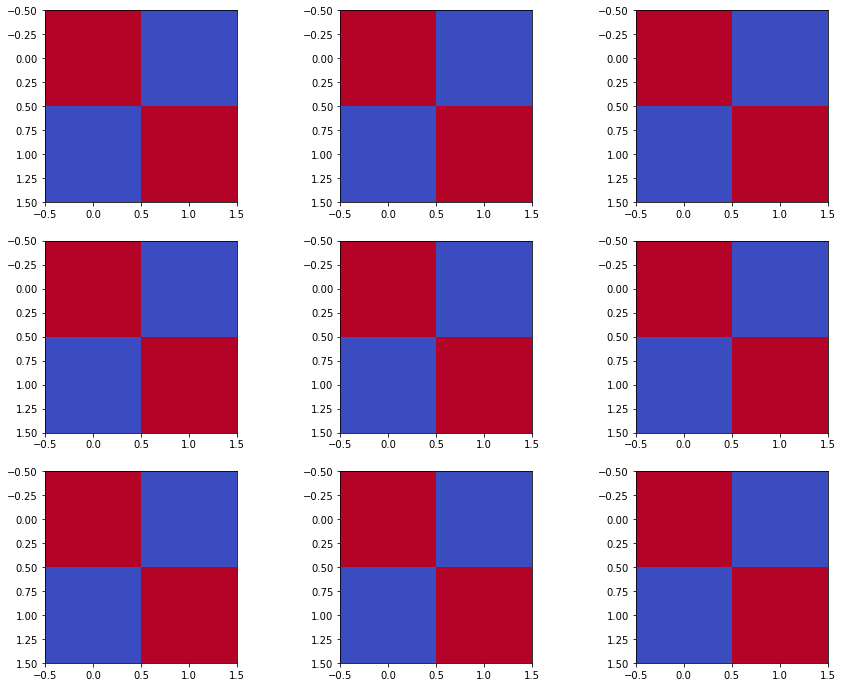

In [97]:
plt.figure(figsize=(15, 12))
ax = 0
corrList = []
for i in range(Y.shape[1]):
    for j in range(factors[0].shape[1]):
        corr, ax = corrEstimate(i, j, Y, factors)
        corrList.append(corr)

n=0 # there is a bug that makes the plot read the same correlation matrix every time, I tried inside the function, and then added the list to separate the variables, and not good
for i in range(Y.shape[1]):
    for j in range(factors[0].shape[1]):
        ax = plt.subplot(3, 3, n+1)
        plt.imshow(corrList[n],cmap='coolwarm',interpolation='nearest')
        n= n+1

### It is obvious that the first estimated chemical matches the first ground truth, more than the other two

### The second estimated chemical matches the third ground truth, 

### The third estimated checmical matches the second ground truth

### The second and third are swapped

# Ch6: Fundamentals of Tensor Analysis & Applications

## 6.1 Scientific Computing Applications

## Second Problem is a survey answers about happiness scores related to 3 conditions. This created a three-way contingency table has as its variables: Happiness reported by participants in a survey (i mode-1 : 3 categories), Number of siblings (j mode-2 : Siblings - 5 categories) and the Years of schooling completed (k mode-3 : Schooling - 4 categories). It is thus a frequency table containing in the cells the number of people with a particular combination of categories. 

## the data is stored in a dat file that reads a 2 dimensional matricised tensor, (12, 5), assuming that reshaping into (3, 4, 5) and swapping the mode-2 and mode-3 in the problem definition in https://three-mode.leidenuniv.nl/ will be ok

## Will decompose with Tucker to find which rank gives the best fit.

In [120]:
import csv

# read flash.dat to a list of lists
datContent = [i.strip().split() for i in open("data/Happiness.dat").readlines()]

X = np.array(datContent)
X.shape

(12, 5)

In [121]:
X = X.reshape(3, 4, 5)
X.shape

(3, 4, 5)

In [163]:
# doing Tucker decomposition
from tensorly.decomposition import tucker
import tensorly as tl
import math



def doTucker (X, rank):
    X = tl.tensor(X,dtype=float)
    core, factors = tucker(X, rank=rank)
    tucker_reconstruction_2 = tl.tucker_to_tensor((core, factors))

    tk_RMSE = math.sqrt(np.square(np.subtract(X,tucker_reconstruction_2)).mean() )
    print ("Tucker " + str(rank) + " RMSE = ", tk_RMSE)
    return core ,factors, tk_RMSE

In [247]:
# doing Tucker decomposition
from tensorly.decomposition import tucker
import tensorly as tl

ranks = []
tucker_RMSE=[]

## two useful functions
np.unravel_index(0, X.shape) # flat linear index to multidimensional index 
np.ravel_multi_index([X.shape[i]-1 for i in range(len(X.shape))], X.shape) # multidimensional index to flat linear index


for i in range(np.prod(X.shape)): # iterate through the flat index
    rank= np.unravel_index(i, X.shape) # get the multidimensional index to use as a rank, in case it does not contain a zero, this will traverse all possible ranks
    if np.all(rank):
        core ,factors, tk_RMSE = doTucker(X, rank)
        tucker_RMSE.append(tk_RMSE)
        ranks.append(str(rank))


max = np.argmin(tucker_RMSE)
print ("Lowest RMSE achieched at rank = " + ranks[max]) # this will show the full matrix rank, 

Tucker (1, 1, 1) RMSE =  12.598852747845193
Tucker (1, 1, 2) RMSE =  12.598852744280288
Tucker (1, 1, 3) RMSE =  12.59885274425921
Tucker (1, 1, 4) RMSE =  12.598852744251092
Tucker (1, 2, 1) RMSE =  12.598852744714836
Tucker (1, 2, 2) RMSE =  5.422717217988446
Tucker (1, 2, 3) RMSE =  5.422717217988797
Tucker (1, 2, 4) RMSE =  5.422717217989062
Tucker (1, 3, 1) RMSE =  12.598852744230822
Tucker (1, 3, 2) RMSE =  5.422717217988598
Tucker (1, 3, 3) RMSE =  5.194856418784414
Tucker (1, 3, 4) RMSE =  5.194852434187298
Tucker (2, 1, 1) RMSE =  12.598852747725521
Tucker (2, 1, 2) RMSE =  12.353237845601098
Tucker (2, 1, 3) RMSE =  12.353281907905796
Tucker (2, 1, 4) RMSE =  12.353162180049729
Tucker (2, 2, 1) RMSE =  12.26573244654067
Tucker (2, 2, 2) RMSE =  4.329851523834253
Tucker (2, 2, 3) RMSE =  4.1639433811974085
Tucker (2, 2, 4) RMSE =  4.111071395674339
Tucker (2, 3, 1) RMSE =  12.26573242990964
Tucker (2, 3, 2) RMSE =  4.30706843030477
Tucker (2, 3, 3) RMSE =  4.013234749236352
Tu

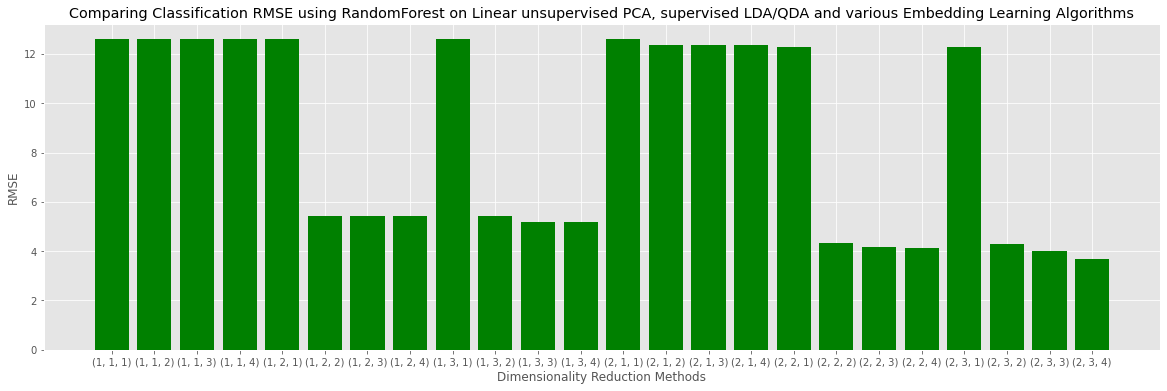

In [245]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure( figsize=(20,6))
plt.style.use('ggplot')

x_pos = [i for i, _ in enumerate(ranks)]

plt.bar(ranks, tucker_RMSE, color='green')
plt.xlabel("Dimensionality Reduction Methods")
plt.ylabel("RMSE")
plt.title("Comparing Classification RMSE using RandomForest on Linear unsupervised PCA, supervised LDA/QDA and various Embedding Learning Algorithms")

plt.xticks(x_pos, ranks)

plt.show()

## Looking at all possible ranks reconstruction error, it seems the highest errors occured when all modes were reduced, but when first mode only was reduced, the error was small, which means it is not very dominant in this dataset, and the third mode seems to be the most dominant.  

In the book ( Kroonenberg, P.M., 2008. Applied multi-way data analysis, Wiley series in probability and statistics. Wiley-Interscience, Hoboken, N.J.) the author showed that rank (2,2,2) was the most fit to this dataset, which is proven here as well. The software he used can be downloaded from https://three-mode.leidenuniv.nl/ , 